# Predicting Text Difficulty

## Load Data 

In [140]:
import pandas as pd
import numpy as np
import spacy
import nltk
import string
from collections import Counter
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [3]:
nlp = spacy.load("en_core_web_sm")

In [95]:
# Dale_Chall Word List 
with open('dale_chall.txt') as f:
    lines = f.readlines()
    
dale_chall_word_list = [word.strip().lower() for word in lines]  
dale_chall_word_set = set(dale_chall_word_list)

# import train and test data 
train_data = pd.read_csv("WikiLarge_Train.csv")
final_test_data = pd.read_csv("WikiLarge_Test.csv")
train_data["id"] = list(range(len(final_test_data), len(final_test_data)+len(train_data)))
train_data = train_data[["id", "original_text", "label"]]

# for feature extraction: 
all_data = pd.concat([final_test_data, train_data])
all_data = all_data.sort_values(by="id", axis=0)
all_data = all_data.set_index("id")
all_data.head(4)

,original_text,label
id,,
0,-2011,NaN
1,-2011,NaN
2,-2000,NaN
3,-1997,NaN


In [7]:
print(train_data.shape, final_test_data.shape)

(416768, 3) (119092, 3)


In [28]:
punctuations = list(string.punctuation)
punctuations = punctuations + ["...", "”", "’", "“", "…"]
punctuations_set = set(punctuations)

original_text_df = all_data[["original_text"]]

def clean_text(row): 
    text = row["original_text"]
    
    text = text.replace("-RRB-", "")
    text = text.replace("-LRB-", "")
    
    # replace any non-alphabetic characters and trailing spaces
    text = text.replace("Å ", "o") 
    text = text.replace("Ã ", "a")
    
    # remove urls
    text = re.sub(r"http[s]?\:[\w\.\/\-]+", "", text) 
    
    # remove any 's
    text = text.replace("'s", "")
    
    # remove any punctuations
    text = re.sub(r"[!\"#$%&\'()*+,\-\./:;<=>?@[\\\]\^_`{\|}~\.\.\.”’“\†\']", "", text)

    text = text.replace("  ", " ")
    text = text.strip()
    text = text.lower()
    return text

original_text_df["clean_text"] = original_text_df.apply(clean_text, axis=1)
original_text_df


,original_text,clean_text
id,,
0,-2011,2011
1,-2011,2011
2,-2000,2000
3,-1997,1997
4,1.636,1636
...,...,...
535855,A Duke Nukem 3D version has been sold for Xbox...,a duke nukem 3d version has been sold for xbox...
535856,"However , it is becoming replaced as a method ...",however it is becoming replaced as a method of...
535857,There are hand gestures in both Hindu and Budd...,there are hand gestures in both hindu and budd...


## Exploratory Data Analysis

In [134]:
print("Train data has length of {} rows".format(len(train_data)))
print("Final test data has length of {} rows".format(len(final_test_data)))

Train data has length of 416768 rows
Final test data has length of 119092 rows


In [135]:
# how balanced are the class labels in the training data 
train_data["label"].value_counts()


0    208384
1    208384
Name: label, dtype: int64

#### Feature Extraction

In [163]:
all_data["cleaned_text"] = original_text_df["clean_text"] 

all_features = all_data.copy()

punctuations = list(string.punctuation)
punctuations = punctuations + ["...", "”", "’", "“", "…", "``"]
punctuations_set = set(punctuations)

# get text length
def get_length(row):
    text = row["cleaned_text"]
    return len(text)

def get_tokens(row): 
    text = row["cleaned_text"]
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [token for token in tokens if (token not in punctuations_set)]
    cleaned_tokens = [token.strip() for token in cleaned_tokens]
    return cleaned_tokens

def get_num_types(row): 
    tokens = row["tokens"]
    types = set(tokens)
    return len(types)

def get_num_tokens(row): 
    tokens = row["tokens"]
    return len(tokens)

def get_difficult_tokens(row): 
    tokens = row["tokens"]
    difficult_tokens = [token for token in tokens if (token not in dale_chall_word_set)]
    return difficult_tokens

def get_num_difficult_tokens(row): 
    difficult_tokens = row["difficult_tokens"]
    return len(difficult_tokens)

def get_prop_difficult_tokens(row): 
    proportion = 0
    num_difficult_tokens = len(row["difficult_tokens"])
    num_tokens = row["num_tokens"]
    if num_tokens != 0:
        proportion = num_difficult_tokens/num_tokens
        
    return proportion

all_features["text_len"] = all_features.apply(get_length, axis=1)
print("1. Done")
all_features["tokens"] = all_features.apply(get_tokens, axis=1) # takes a long time 
print("2. Done")
all_features["num_tokens"] = all_features.apply(get_num_tokens, axis=1)
print("3. Done")
all_features["num_types"] = all_features.apply(get_num_types, axis=1)
print("4. Done")
all_features["difficult_tokens"] = all_features.apply(get_difficult_tokens, axis=1)
print("5. Done")
all_features["num_difficult_tokens"] = all_features.apply(get_num_difficult_tokens, axis=1)
print("6. Done")
all_features["prop_difficult_tokens"] = all_features.apply(get_prop_difficult_tokens, axis=1)
print("7. Done")


1. Done
2. Done
3. Done
4. Done
5. Done
6. Done
7. Done


array([[<AxesSubplot:title={'center':'Text Length Distribution'}>]],
      dtype=object)

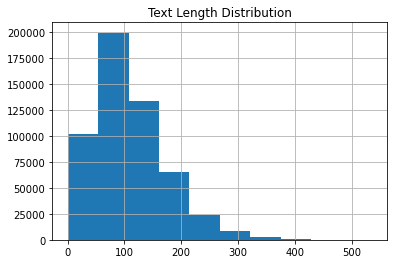

In [211]:
# Text Length Distribution 
all_features[["text_len"]].rename({"text_len": "Text Length Distribution"}, axis=1).hist(bins=10)


array([[<AxesSubplot:title={'center':'Text Length by Tokens Distribution'}>]],
      dtype=object)

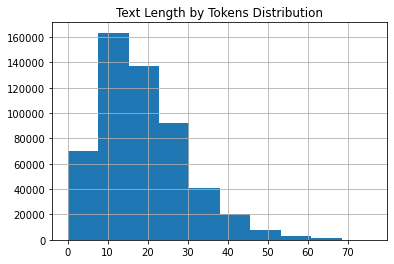

In [213]:
# Text Length by Tokens Distribution 
all_features[["num_tokens"]].rename({"num_tokens": "Text Length by Tokens Distribution"}, axis=1).hist(bins=10)


array([[<AxesSubplot:title={'center':'Number of Types Per Text Distribution'}>]],
      dtype=object)

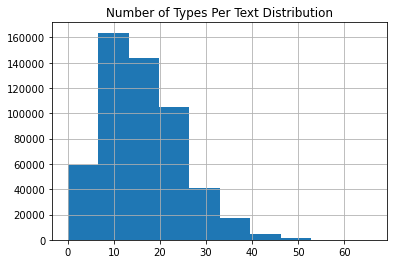

In [215]:
# Text Length by Types Distribution 
all_features[["num_types"]].rename({"num_types": "Number of Types Per Text Distribution"}, axis=1).hist(bins=10)


In [139]:
# explore the most occurring words
all_tokens = []

for idx, row in all_features.iterrows():
    tokens = row["tokens"]
    all_tokens.extend(tokens)

tokens_count_dict = Counter(all_tokens) 

token_count_df = pd.DataFrame.from_dict(tokens_count_dict, orient="index") \
.reset_index().rename({0: "token_count", "index": "token"}, axis=1) \
.sort_values(by="token_count", axis=0, ascending=False)
token_count_df.head(4)

,token,token_count
22,the,734621
51,of,372237
28,in,325117
40,and,269142


<AxesSubplot:xlabel='token'>

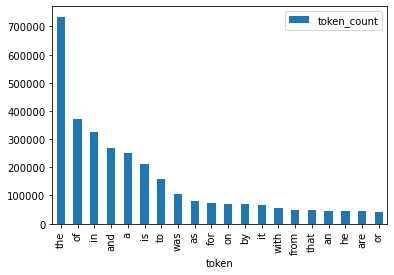

In [141]:
# plot the top 20 most occuring words 
token_count_df[:20].plot.bar(y="token_count", x="token", rot=90)

In [144]:
# check whether the top 20 most occurring words are found in Dale Chall Word List

for token in list(token_count_df["token"][:20]):
    if token in dale_chall_word_set: 
        print(True)
    else: 
        print(False)
        

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


All of them are found in the Dale Chall Word List. 

### Chi-square Test for Feature Selection 

Conduct Chi-square Test on numerical features to see whether any of them are independent of the response variable.

text_len                 0.000000
num_tokens               0.000000
num_types                0.000000
num_difficult_tokens     0.000000
prop_difficult_tokens    0.056828
dtype: float64


<AxesSubplot:>

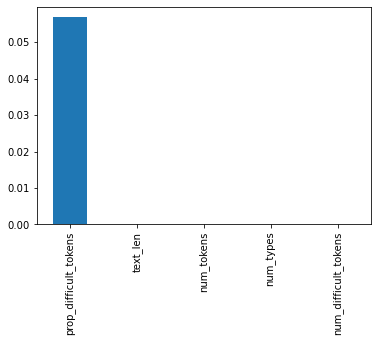

In [166]:
# https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html

from sklearn.preprocessing import MinMaxScaler

training = all_features[all_features["label"].isnull()==False]
training_features = training[["text_len", "num_tokens", "num_types", 
                              "num_difficult_tokens", "prop_difficult_tokens"]]

training_labels = training["label"]
training_labels = training_labels.astype(int)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(training_features)

chi_scores = chi2(scaled_features, training_labels)

p_values = pd.Series(chi_scores[1],index = training_features.columns)
print(p_values)
p_values.sort_values(ascending = False, inplace = True)
p_values.plot.bar()


It is interesting that the proportion of difficult tokens is the only features that is not highly dependent on the response variable. We will not consider this as one of the features. 

### Stop: Read Note

Please run models_run.py to train and tune the models. After that, please run the eval_model.py in order to use the best model to make predictions on the validation and final test data. The python files will output .npy and .csv files for evaluating the models. Some of the .npy files are needed to continue on the Jupyter Notebook. After running the two python files, please continue the Jupyter notebook. 

From here on, the predictions.npy, the feature_importances.npy and final_predictions.npy are needed.

### Sensitivity Analysis: Training data size vs Accuracy 

In [296]:
# Token Representation
training = all_features[all_features["label"].isnull() == False]
features_list = ["cleaned_text", "text_len", "num_tokens", "num_types", "num_difficult_tokens"]

training_features = training[features_list]

training_labels = training["label"]
training_labels = training_labels.astype(int)

X_tr, X_te, y_train, y_test = train_test_split(training_features,
                                               training_labels,
                                               test_size=0.2,
                                               random_state=0)

max_feat = 1000

mapper = DataFrameMapper([("cleaned_text", CountVectorizer(binary=True, min_df=5, max_df=0.8, max_features=max_feat)),
                          (features_list[1:], None)])

print("Transforming Features...")
X_train = mapper.fit_transform(X_tr)
X_test = mapper.transform(X_te)

print("Shapes of Training and Test Data:")
print(X_train.shape, X_test.shape)


Transforming Features...
Shapes of Training and Test Data:
(333414, 1004) (83354, 1004)


In [316]:
training_data_sizes = [10, 100, 1000, 5000]
trainscores_sens = []
testscores_sens = []

for limit in training_data_sizes:
    best_model_rf = RandomForestClassifier(random_state=0, 
                                           n_estimators=500, 
                                           max_features=30)
    print("fitting with limit of {}".format(limit))
    best_model_rf.fit(X_train[:limit], y_train[:limit])
    print("scoring...")
    rf_train_score = best_model_rf.score(X_train, y_train)
    rf_test_score = best_model_rf.score(X_test, y_test)
    trainscores_sens.append(rf_train_score)
    testscores_sens.append(rf_test_score)
    print("Done!")
    


fitting with limit of 10
scoring...
Done!
fitting with limit of 100
scoring...
Done!
fitting with limit of 1000
scoring...
Done!
fitting with limit of 5000
scoring...
Done!


<AxesSubplot:title={'center':'Changes in Accuracy relative to Training Data Size'}, xlabel='Training Data Size'>

<Figure size 1440x1440 with 0 Axes>

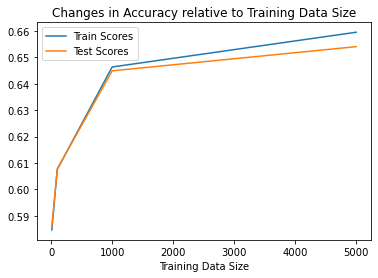

In [321]:
sens_df = pd.DataFrame.from_dict({"Training Data Size": training_data_sizes, 
                                  "Train Scores": trainscores_sens, 
                                  "Test Scores": testscores_sens})
sens_df.plot(x="Training Data Size", 
             y=["Train Scores", "Test Scores"], 
             kind="line", title="Changes in Accuracy relative to Training Data Size", 
             legend=True)


### "Best" Model Evaluation

In [ ]:
# load predictions and feature_importances from the best model 
with open('predictions.npy', 'rb') as f:
    predictions = np.load(f)
    
with open('feature_importances.npy', 'rb') as g:
    features_importances = np.load(g)
    

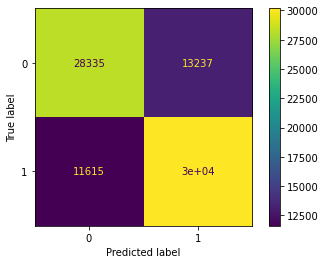

In [277]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0, 1] 
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()


#### ROC Curve

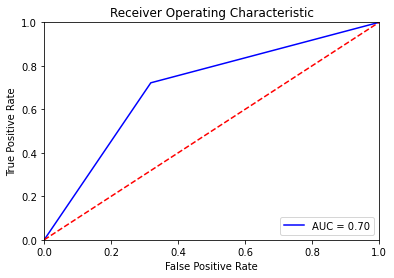

In [232]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### Feature Importance Analysis

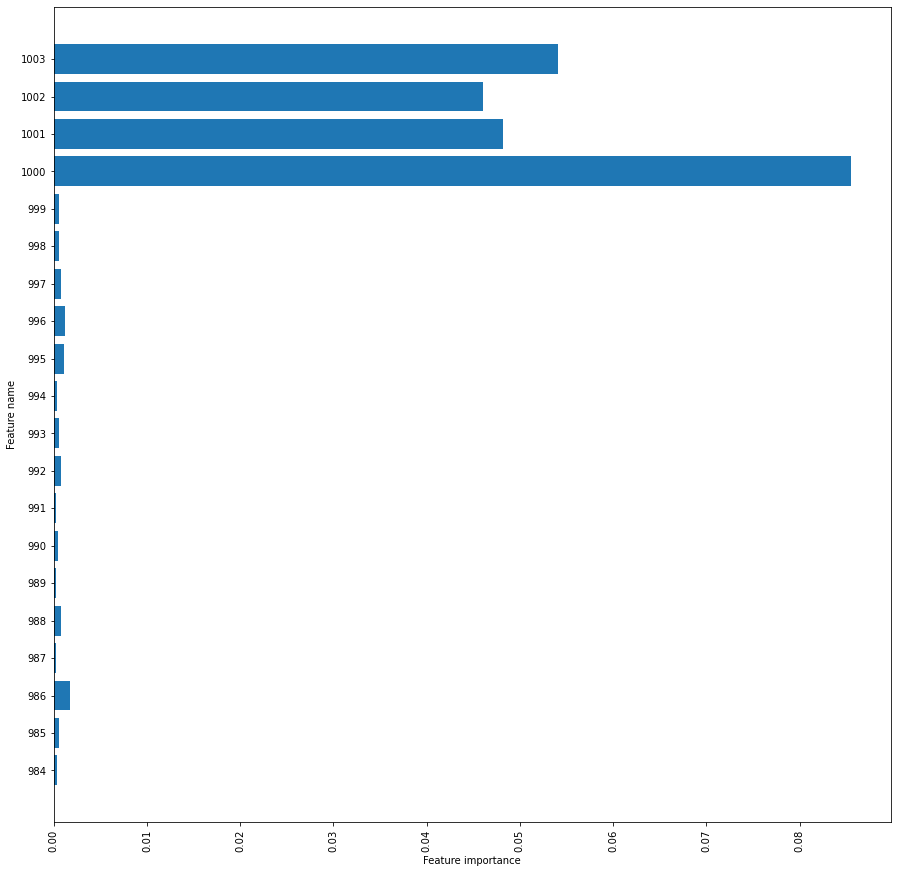

In [264]:
# Feature Importance Analysis

# if the best model is a Random Forest 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# function from adspy_shared_utilities.py file

features_names = list(range(X_train.shape[1]))

def plot_feature_importances(features_imp, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), features_imp)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
    plt.xticks(rotation=90)

figure(figsize=(15, 15))
plot_feature_importances(features_importances[-20:], features_names[-20:])


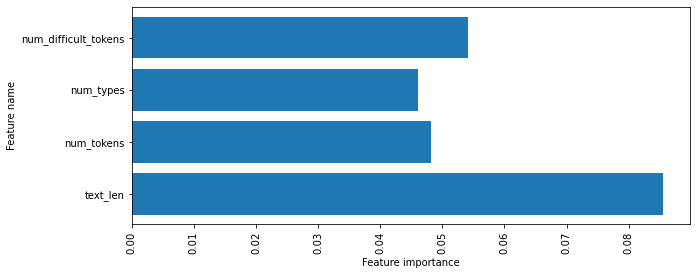

In [255]:
# only the numerical features 
features_names = list(range(X_train.shape[1]))

def plot_feature_importances(features_imp, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), features_imp)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
    plt.xticks(rotation=90)
    
numerical_features = ["text_len", "num_tokens", "num_types", "num_difficult_tokens"]

figure(figsize=(10, 4))
plot_feature_importances(features_importances[-4:], numerical_features)


In [288]:
# csv file for failure analysis
failure_analysis = X_te[["cleaned_text"]].copy()
failure_analysis["predictions"] = predictions
failure_analysis["true label"] = y_test
failure_analysis.to_csv("failure_analysis.csv", index=True)

### Kaggle Submission

In [315]:
final_testing = all_features[all_features["label"].isnull() == True]
final_testing_features = final_testing[features_list]


with open('final_predictions.npy', 'rb') as t:
    final_predictions = np.load(t)

final_testing["predicted_label"] = final_predictions
csv_final_testing = final_testing[["predicted_label"]]
csv_final_testing = csv_final_testing.rename({"predicted_label": "label"}, axis=1)
csv_final_testing.to_csv("prediction_submission.csv", index=True)
